**<h1><font color='indigo'> Generating Short E-mail Response Suggestions using Natural Language Processing**

In [1]:
# Importing Necessary Libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import gdown
import regex as re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# <font color='orange'>1. Understanding the Problem Statement

##<font color='brown'> 1.1 Problem Description

**Description**

In the today's modern world, E-mail has been an important medium of communication not only in professional life but also in our personal lives. Reading and responding lots of emails everyday sometimes becomes hectic for an individual. Is it possible to build an automated system that can read your emails and suggest appropriate short response accordingly that can be written with just one click as the reply?

The answer is YES...! We can use advanced deep learning and natural language processing techniques to bulid such a smart system. 

**Objective**

Given an E-mail text as input, generate relevant short response as text output.

##<font color='brown'>1.2 Useful Links

**Data Source** - https://www.kaggle.com/datasets/atharvjairath/empathetic-dialogues-facebook-ai?select=emotion-emotion_69k.csv

**Research Paper** - https://arxiv.org/abs/1606.04870

##<font color='brown'>1.3 Real World Constraints

1. Generate most relevant positive and negative short responses.
2. Irrevalnt response could hamper user experience.
3. Latency should be minimal.

# <font color='orange'>2. Machine Learning Problem

##<font color='brown'>2.1 About Data

###2.1.1 Data Description 

**Data Source:** https://www.kaggle.com/datasets/atharvjairath/empathetic-dialogues-facebook-ai?select=emotion-emotion_69k.csv

Data is in single csv file.

<pre>
<b>File_name:</b> emotion-emotion_69k.csv
File_size: 15.95 MB
No. of columns = 7
No. of rows = 64636

Even though there are 7 columns, only 2 columns are useful for our task.
Useful columns: 'empathetic_dialogues', 'labels'

<b>Columns info:</b>
'empathetic_dialogues' -> Input email text
'labels' -> expected response text as output
</pre>

###2.1.2 Data Point Sample

A single record sample from the data could be -

<pre>
<b>Example: </b>
'empathetic_dialogues' = Hi how are you doing today
'labels' = doing good.. how about you
</pre>

##<font color='brown'>2.2 Mapping Real World Problem to Machine Learning Problem

###2.2.1 Type of Problem

Here input is sequence of text and output is also a sequence of text, hence it's a deep learning problem that belongs to Natural Language Processing field.

https://en.wikipedia.org/wiki/Natural_language_processing 

###2.2.2 Performance Metrics

Model performance can be evaluated using its BLEU (Bilingual Evaluation Understudy) score, which indicates how similar the candidate text is to the reference texts, with values closer to one representing more similar texts.

<b>Why BLEU Score? </b>

*   It is quick and inexpensive to calculate.
*   It is easy to understand.
*   It is language independent.
*   It correlates highly with human evaluation.
*   It has been widely adopted.

We want our model to have BLEU score close to 1.0 (Highest)

https://machinelearningmastery.com/calculate-bleu-score-for-text-python/ 

# <font color='orange'>3. Exploratory Data Analysis

## <font color='brown'>3.1 Loading Data

###3.1.1 Downloading data using gdown

In [2]:
# Download data using gdown
!gdown 1T7I3KxNYncL30KdBuaWZjzPj4PIGAWmz

Downloading...
From: https://drive.google.com/uc?id=1T7I3KxNYncL30KdBuaWZjzPj4PIGAWmz
To: /content/emotion-emotion_69k.csv
100% 16.7M/16.7M [00:00<00:00, 131MB/s] 


###3.2.2 Reading and understanding data

In [3]:
# read data
data = pd.read_csv("emotion-emotion_69k.csv")
print("Data Sample")
data.head()

Data Sample


,Unnamed: 0,Situation,emotion,empathetic_dialogues,labels,Unnamed: 5,Unnamed: 6
0,0,I remember going to the fireworks with my best...,sentimental,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju...",NaN,NaN
1,1,I remember going to the fireworks with my best...,sentimental,Customer :This was a best friend. I miss her.\...,Where has she gone?,NaN,NaN
2,2,I remember going to the fireworks with my best...,sentimental,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...,NaN,NaN
3,3,I remember going to the fireworks with my best...,sentimental,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.,NaN,NaN
4,4,I remember going to the fireworks with my best...,sentimental,Customer :Where has she gone?\nAgent :,We no longer talk.,NaN,NaN


In [4]:
# data shape and description
print(f"Data shape: {data.shape}")
print()
print("Data info:")
data.info()

Data shape: (64636, 7)

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64636 entries, 0 to 64635
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            64636 non-null  int64 
 1   Situation             64636 non-null  object
 2   emotion               64632 non-null  object
 3   empathetic_dialogues  64636 non-null  object
 4   labels                64636 non-null  object
 5   Unnamed: 5            113 non-null    object
 6   Unnamed: 6            5 non-null      object
dtypes: int64(1), object(6)
memory usage: 3.5+ MB


## <font color='brown'>3.2 Check and Filter Useful Data

###3.2.1 Filter unwanted columns

We just want input and ouput text for model training hence we caan delete other columns.

In [5]:
data_df = data[['empathetic_dialogues', 'labels']]
data_df.head()

,empathetic_dialogues,labels
0,Customer :I remember going to see the firework...,"Was this a friend you were in love with, or ju..."
1,Customer :This was a best friend. I miss her.\...,Where has she gone?
2,Customer :We no longer talk.\nAgent :,Oh was this something that happened because of...
3,Customer :Was this a friend you were in love w...,This was a best friend. I miss her.
4,Customer :Where has she gone?\nAgent :,We no longer talk.


###3.2.2 Check Duplicate Data Points

In [6]:
# Checkig duplicate data points in the data_df
duplicates_count = data_df.duplicated(keep='first').sum()
print(f"No. of duplicate data point: {duplicates_count}")
print(f"No. of total data points: {len(data_df)}")
print(f"Percentage of duplicate data points: {duplicates_count*100/len(data_df)} %")

No. of duplicate data point: 22
No. of total data points: 64636
Percentage of duplicate data points: 0.03403675970047652 %


In [7]:
# Deleting duplicate data points
data_df = data_df.drop_duplicates(keep='first')
print(f"No. of data points after dropping duplicates: {len(data_df)}")

No. of data points after dropping duplicates: 64614


###3.2.3 Check nan values

In [8]:
# Check if nan values are in data
data_df.isna().sum()

empathetic_dialogues    0
labels                  0
dtype: int64

**Observation(s) :**

There are no nan values in the data_df.

###3.2.4 Filter wrong entries and cleaning text

Some entries in empathetic_dialogues column has wrong entries other than text that should be removed. We will eliminate records with text length less than 4 words. For example-

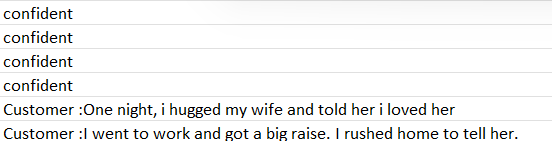

In [9]:
# Deleting entries with less than 4 words as input
IP_SENT_MINLENGTH = 3
data_df = data_df[data_df['empathetic_dialogues'].str.split().str.len() >= IP_SENT_MINLENGTH]

In [10]:
# Removing unwanted words like customer, agent, \n from input text
def cleaner(x):
    """
    removes unwanted words(customer, agent) and characters(\n) and returns clean text
    """
    if '\n' in x:
        sent = re.split(r'\n', x, 1)[0]
    else:
        sent = x
    if ':' in x:
        sent = re.split(r':', sent, 1)[1]

    return sent

data_df['empathetic_dialogues'] = data_df['empathetic_dialogues'].apply(cleaner)
print("Cleaned data sample:")
print(f"Shape: {data_df.shape}")
data_df.head()

Cleaned data sample:
Shape: (64573, 2)


,empathetic_dialogues,labels
0,I remember going to see the fireworks with my ...,"Was this a friend you were in love with, or ju..."
1,This was a best friend. I miss her.,Where has she gone?
2,We no longer talk.,Oh was this something that happened because of...
3,"Was this a friend you were in love with, or ju...",This was a best friend. I miss her.
4,Where has she gone?,We no longer talk.


###3.2.5 Check length of text

**Histograms**

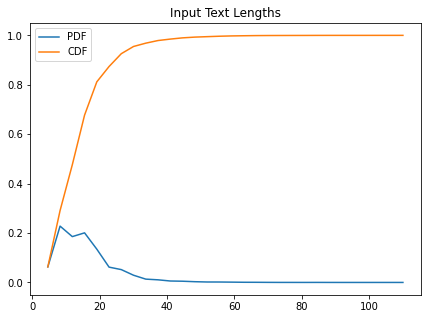

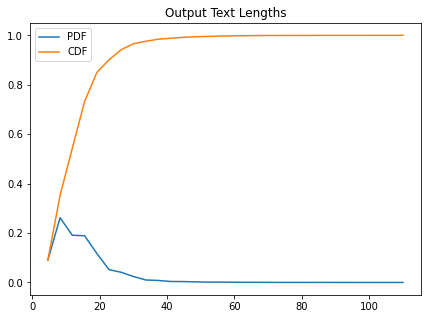

In [11]:
# Checking length of text using histogram
ip_lengths = []
op_lengths = []

for text in data_df['empathetic_dialogues']:
    length = len(text.split())
    ip_lengths.append(length)

for text in data_df['labels']:
    length = len(text.split())
    op_lengths.append(length)

# Plot histograms and cdf for input text lengths
fig = plt.figure(figsize=(7,5))
count, bins_count = np.histogram(ip_lengths, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, label='PDF')
plt.plot(bins_count[1:], cdf, label='CDF')
plt.title("Input Text Lengths")
plt.legend()
plt.show()

# Plot histograms and cdf for output text lengths
fig = plt.figure(figsize=(7,5))
count, bins_count = np.histogram(op_lengths, bins=30)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], pdf, label='PDF')
plt.plot(bins_count[1:], cdf, label='CDF')
plt.title("Output Text Lengths")
plt.legend()
plt.show()

**Observation(s) :**

1. Around 98% of records have input text length less than 50
2. Around 95% of records have output text length less than 30
3. We aim to generate short responses, we will limit max word length to 12 which includes around 60% records

###3.2.6 Filter by length of text

We want to generate short responses hence we will select labels with less than 12 words and input text with less than 50 words

In [12]:
IP_SENT_MAXLENGTH = 50
OP_SENT_MAXLENGTH = 12

# filtering by length of input text
data_df = data_df[(data_df['empathetic_dialogues'].str.split().str.len() >= IP_SENT_MINLENGTH)
                & (data_df['empathetic_dialogues'].str.split().str.len() <= IP_SENT_MAXLENGTH)]

# filtering by length of output text
data_df = data_df[data_df['labels'].str.split().str.len() <= OP_SENT_MAXLENGTH]
print("Data Sample: ")
print(f"Shape: {data_df.shape}")
data_df.sample(5)

Data Sample: 
Shape: (37944, 2)


,empathetic_dialogues,labels
5643,I am not proud to be from New York.,How come?
28564,"Yeah but, it won't be quite the same.",At least it's better than having nothing to use
18138,The anniversaries for my Daddy and my sisters ...,Sorry to hear. Will you be planning anything ...
5615,I was amazed how much I liked Mission Impossible.,how many series did you watch?
23506,"well, true. me too",I cant wait for the final episode


In [13]:
data_df.sample(20)

,empathetic_dialogues,labels
43711,"They never learn, do they ?",This one did eventually.
40548,I'm glad you got your money back.,Me too - I really needed it
32480,Everyone has their strengths and weaknesses. H...,"I am , he is just more gifted than me"
34253,"No, I've never been there either.",You should look at it - such an amazing city
1340,"No, we are working on sorting things out but I...",Did you know the person who was with him?
53533,Hasn't everyone done so at some point?,haha I guess so. But they knew it was me...
21222,I am tired of feeling like I have to compete f...,time to look for one that deserves you
50436,It the trash can damaged?,No by my trash got dumped all over the place.
49313,"HAHAHA no I had to go get stitches, I was horr...",that sounds like a crazy day
32366,Who is Carson Wentz? I believe he is a footbal...,"He is the Eagles QB, he tore his ACL last year"


## <font color='brown'>3.3 Most Frequent Words

###3.3.1 Most Frequent Words in Input Text 

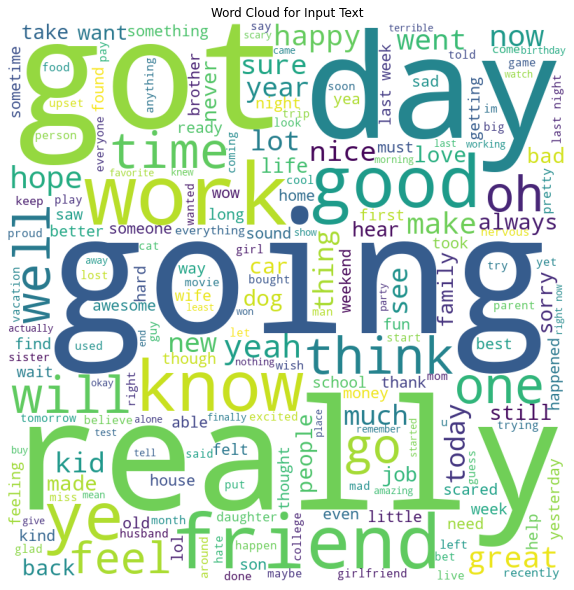

In [14]:
# Ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
# Plot word cloud
words = ''
 
# iterate through the csv file
for val in data_df['empathetic_dialogues']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Word Cloud for Input Text")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**Observation(s) :**

1. Input text contains variety of words
2. Frequently occuring words are quite random and not biased towards any particular sentiment or topic

###3.3.2 Most Frequent Words in Output Text 

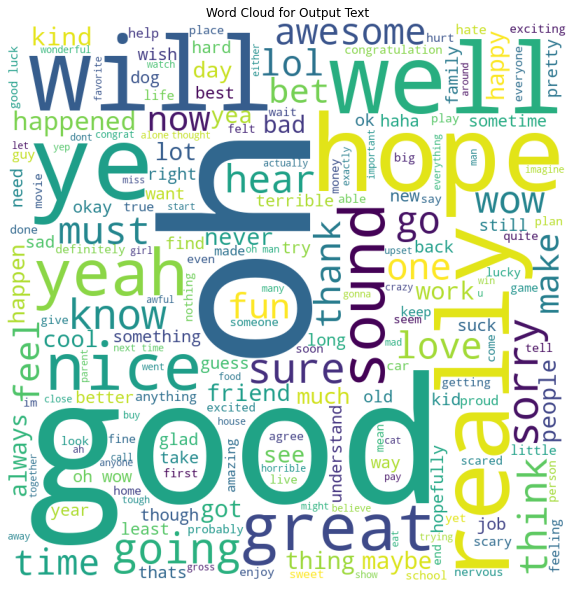

In [15]:
# Ref: https://www.geeksforgeeks.org/generating-word-cloud-python/
# Plot word cloud
words = ''
 
# iterate through the csv file
for val in data_df['labels']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.title("Word Cloud for Output Text")
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

**Observation(s) :**

1. Most frequent words in the ouput text are the words that we typically use in short email responses
2. Words in output text data appear to be biased towards positive responses 

# <font color='orange'>4. Pre-processing text data

## <font color='brown'>4.1 Cleaning Text

We have to remove punctuations (except . and ?), abbrevations, multiple spaces, ... etc. and we have to change it to lower case.

In [16]:
# Defining funtion to preprocess data

def preprocess_1(text):
    """
    converts text to lower case and removes unwanted punctuations, extra spaces,
    abbrevations etc. and returns clean text.
    """

    # lower case
    text = text.lower()

    # multiple occurences
    text = re.sub(r'\s+',' ', text)
    text = re.sub(r'\.{2,}','.', text)

    # Contractions
    # Ref: https://stackoverflow.com/questions/43018030/replace-apostrophe-short-words-in-python
    
    # specific
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"c\'mon", "come on", text)
    # general
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    

    # Removing unwanted words
    text = re.sub(r"hahaha", '', text)
    text = re.sub(r"wtf", '', text)
    text = re.sub(r"wth", '', text)
    text = re.sub(r"yep", 'yes', text)
    text = re.sub(r"sucks", 'is bad', text)
    text = re.sub(r"geez", '', text)
    text = re.sub(r"lol", '', text)

    # Don't remove ?
    text = text.replace("?", " ?")

    # Remove all other punctuations
    text = re.sub(r"[!\"#$%&'()*+,-\/:;<=>@[\]^_`{|}~]", '', text)

    # Remove emojis
    # Ref: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoj = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002500-\U00002BEF"  # chinese char
            u"\U00002702-\U000027B0"
            u"\U00002702-\U000027B0"
            u"\U000024C2-\U0001F251"
            u"\U0001f926-\U0001f937"
            u"\U00010000-\U0010ffff"
            u"\u2640-\u2642" 
            u"\u2600-\u2B55"
            u"\u200d"
            u"\u23cf"
            u"\u23e9"
            u"\u231a"
            u"\ufe0f"  # dingbats
            u"\u3030"
                      "]+", re.UNICODE)
    
    text = re.sub(emoj, '', text)

    return text

# Apply preprocess1
data_df["clean_input"] = data_df["empathetic_dialogues"].apply(preprocess_1)
data_df["clean_output"] = data_df["labels"].apply(preprocess_1)

In [17]:
data_df.sample(10)

,empathetic_dialogues,labels,clean_input,clean_output
15283,"I hope so because as of right now, I feel like...","Ha, I bet it will be fine",i hope so because as of right now i feel like ...,ha i bet it will be fine
21394,What all did you buy?,I bought some clothes and a new TV,what all did you buy ?,i bought some clothes and a new tv
46008,I ate 20 Big Macs for dinner tonight.,"Wow, that is really impressive!",i ate 20 big macs for dinner tonight,wow that is really impressive
8254,Yes typically kids are nicer and more open. Ad...,"Yea, I guess that happens with time. Wish it w...",yes typically kids are nicer and more open adu...,yea i guess that happens with time wish it was...
33697,sounds like fun,"Yes, we are going to play video games all week...",sounds like fun,yes we are going to play video games all weekend
30777,I can beat my chest about the outcome of tomor...,You must be quite confident in your abilities!,i can beat my chest about the outcome of tomor...,you must be quite confident in your abilities
14110,"I ordered for a pizza,she brought a hambugger,...",Oh no! I hope you were able to get over the di...,i ordered for a pizzashe brought a hambuggeri ...,oh no i hope you were able to get over the dis...
30303,"yes i did , but i needed the part to get my ca...",How long will that take to happen?,yes i did but i needed the part to get my car...,how long will that take to happen ?
61444,I moved to a new area and feel isolated becaus...,Why did you move?,i moved to a new area and feel isolated becaus...,why did you move ?
13726,Thanks! I don't like it a lot but it's better ...,"Absolutely, never be a victim.",thanks i do not like it a lot but it is better...,absolutely never be a victim


In [18]:
data_df.shape

(37944, 4)

In [19]:
# Save data for clusterig approach
clustering_df = data_df.copy()
clustering_df = clustering_df.drop(['empathetic_dialogues', 'labels'], axis=1)
clustering_df.head(3)

,clean_input,clean_output
1,this was a best friend i miss her,where has she gone ?
2,we no longer talk,oh was this something that happened because of...
3,was this a friend you were in love with or jus...,this was a best friend i miss her


In [20]:
clustering_df.to_csv("clustering_df.csv", index=False)

## <font color='brown'>4.2 Add special tokens



We can not dend text directly to the models, we need to prepare it first. We can add some extra tokens like \<START> and \<END> so that our model can understand begining and end of statement. them we can tokenize text and convert it to numbers to feed the model.

In [ ]:
# drop unwanted columns
final_df = data_df.copy()
final_df = final_df.drop(['empathetic_dialogues', 'labels'], axis=1)

#add <START> and <END> tokens
final_df['enc_input'] = final_df['clean_input']
final_df['dec_input'] = '<start> ' + final_df['clean_output']
final_df['dec_output'] = final_df['clean_output'] + ' <end>'

# drop duplicate columns
final_df = final_df.drop(['clean_input', 'clean_output'], axis=1)

# sample data
final_df.sample(5)

,enc_input,dec_input,dec_output
61960,it is bad so much,<start> yeah its a tought thing to have to dea...,yeah its a tought thing to have to deal with <...
61739,oh damn that is bad so much i am sorry but if ...,<start> i guess so but i am so envious of him,i guess so but i am so envious of him <end>
2294,that seems bad and i am sorry to hear that wha...,<start> my father day 3 weeks agoi still can n...,my father day 3 weeks agoi still can not belie...
33364,nice have you gone cruising in it yet ?,<start> yes i am so envious of him,yes i am so envious of him <end>
49016,i could not believe my friend won the lottery,<start> wow how much,wow how much <end>


In [ ]:
# save data
final_df.to_csv("final_data.csv", index=False)

###**For next steps, refer 2_baseline model.ipynb**